# Monte Carlo Simulation for Portfolio Risk Assessment
## Part 1: The Setup

### **What's in our portfolio?**
\
Assume we've invested in three assets: US stocks (A), bonds (B) and gold (C) with 50% of our money going into stocks, 30% into bonds, 20% into gold.
That’s our **weights vector**:
$w = \begin{bmatrix}0.5 \\ 0.3 \\ 0.2\end{bmatrix}$

### **How do these assets behave individually?**
\
We use two variables to describe the behaviour of each asset - *mean return* ie how much it goes up on average day and *volatility* ie how much it wiggles up/down around the mean.
So for our three assets (numbers are generated randomly):

- Means: $\mu = [0.0005, 0.0002, 0.0003]$
- Volatilities: $\sigma = [0.010, 0.015, 0.012]$

### **Correlations**
\
Assets are not independent. Sometimes stocks and bonds move in opposite directions, sometimes together.  
We describe that with **correlations** (between −1 and +1).
In our case:  
- Correlation between stocks and bonds: $\rho_{AB}= 0.20$ (weak positive)  
- Correlation between stocks and gold: $\rho_{AC} = 0.10$ (very weak positive)  
- Correlation between bonds and gold: $\rho_{BC} = 0.05$ (almost independent)

### **The Covariance Matrix**
\
We combine volatilities and correlations into a *covariance matrix* $\Sigma$ which tells us how each pair of assets moves together.

- On the diagonal $(i=j)$, it’s just the variance: $\sigma_i^2\$.  
- Off-diagonal terms use correlation and the product of volatilities.
\
So the covariance matrix is:

$$
\Sigma=
\begin{bmatrix}
\sigma_A^2 & \rho_{AB}\,\sigma_A\sigma_B & \rho_{AC}\,\sigma_A\sigma_C \\
\rho_{AB}\,\sigma_A\sigma_B & \sigma_B^2 & \rho_{BC}\,\sigma_B\sigma_C \\
\rho_{AC}\,\sigma_A\sigma_C & \rho_{BC}\,\sigma_B\sigma_C & \sigma_C^2
\end{bmatrix}
$$

In [38]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
w = np.array([0.5, 0.3, 0.2])
mu = np.array([0.0005, 0.0002, 0.0003])
sigma = np.array([0.010, 0.015, 0.012])  

corr = np.array([
    [1.0, 0.20, 0.10],
    [0.20, 1.0, 0.05],
    [0.10, 0.05, 1.0]
])

Sigma = np.outer(sigma, sigma) * corr


### **Portfolio Mean Return**
The expected return of the whole portfolio is just a **weighted average** of the individual means.

Formula:
$$
\mu_p = w^\top \mu
$$

### **Portfolio Variance**
\
Portfolio variance is a statistical value that assesses the degree of dispersion of the returns of a portfolio.

Formula:
$$
\sigma_p^2 = w^\top \Sigma w
$$

- If assets are uncorrelated, risks cancel each other out (less risky).  
- If assets are highly correlated, risks add up (more risky).  

So the covariance matrix $\Sigma$ is the glue that tells us how risks interact.
\
To get back to normal volatility, just take square root:

$$ 
\sigma_p = \sqrt{\sigma_p^2}
$$

That’s the portfolio’s **daily volatility** (standard deviation of returns).



In [60]:
from scipy.stats import norm
import numpy as np
import pandas as pd

mu_p = w @ mu
sigma_p = np.sqrt(w @ Sigma @ w)


print("Portfolio mean return (daily):", mu_p)
print("Portfolio volatility (daily):", sigma_p)

def analytic_VaR_ES(confidence):
    alpha = 1 - confidence
    z = norm.ppf(alpha)
    VaR = -(mu_p + z * sigma_p)
    ES = -(mu_p - sigma_p * norm.pdf(z) / alpha)
    return VaR, ES

Portfolio mean return (daily): 0.00037
Portfolio volatility (daily): 0.007968061244744546


## Part 2: The Simulation
We assume returns follow a **multivariate normal distribution**:

$$
R \sim \mathcal{N}(\mu, \Sigma)
$$

where $R$ is a vector of asset returns, $\mu$ is the vector of means, and $\Sigma$ is the covariance matrix.
\
Generate $N$ random draws (e.g., $N = 100,000)$.  Each draw is a possible “next day” for all 3 assets.
Compute portfolio return for each draw:

$$
R_p = w^\top R
$$

Now you have 100,000 simulated portfolio returns → we can study them.


In [63]:
N = 100_000
# Simulate correlated asset returns
# Each row = one simulated "next day" for all 3 assets
R_sim = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)

# Compute portfolio returns for each simulation
R_p_sim = R_sim @ w  

print("First 5 simulated portfolio returns:", R_p_sim[:5])

First 5 simulated portfolio returns: [-0.00746146 -0.00742683 -0.00384565 -0.0061889  -0.0051388 ]


---
From these simulated portfolio returns we can now compute:

- **Histogram**: visualise the distribution.  
- **Empirical VaR**: the 5th percentile (for 95% confidence).  
- **Empirical ES**: average of the worst 5% of outcomes.  
- Compare with our **analytic VaR** to see how close the normal assumption is.

---
### Empirical VaR and ES

In [67]:
def empirical_VaR_ES(confidence):
    cutoff = np.percentile(R_p_sim, (1-confidence)*100)
    VaR = -cutoff
    ES = -R_p_sim[R_p_sim <= cutoff].mean()
    return VaR, ES

---
## Part 3: Analytical vs Empirical 

In [70]:
for confidence in [0.95, 0.99]:
    VaR_a, ES_a = analytic_VaR_ES(confidence)
    VaR_e, ES_e = empirical_VaR_ES(confidence)

    diff_VaR = 100 * (VaR_e - VaR_a) / VaR_a
    diff_ES = 100 * (ES_e - ES_a) / ES_a

    print(f"\n--- {int(confidence*100)}% Confidence Level ---")
    print(f"Analytical VaR: {VaR_a:.5f} | Empirical VaR: {VaR_e:.5f} | % Diff: {diff_VaR:.2f}%")
    print(f"Analytical ES : {ES_a:.5f} | Empirical ES : {ES_e:.5f} | % Diff: {diff_ES:.2f}%")



--- 95% Confidence Level ---
Analytical VaR: 0.01274 | Empirical VaR: 0.01273 | % Diff: -0.08%
Analytical ES : 0.01607 | Empirical ES : 0.01599 | % Diff: -0.46%

--- 99% Confidence Level ---
Analytical VaR: 0.01817 | Empirical VaR: 0.01806 | % Diff: -0.60%
Analytical ES : 0.02087 | Empirical ES : 0.02068 | % Diff: -0.91%


---
### Histogram with VaR and ES

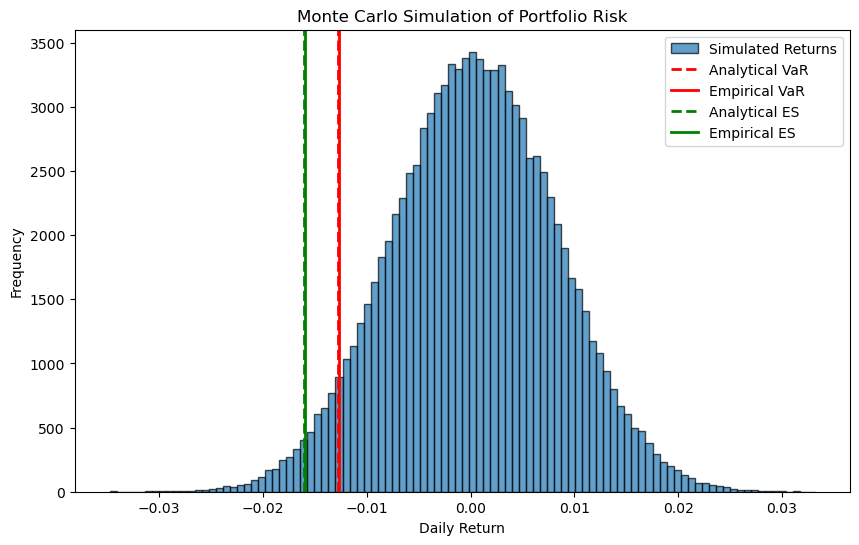

In [73]:
confidence = 0.95  # pick one to visualize
VaR_a, ES_a = analytic_VaR_ES(confidence)
VaR_e, ES_e = empirical_VaR_ES(confidence)

plt.figure(figsize=(10,6))
plt.hist(R_p_sim, bins=100, edgecolor='k', alpha=0.7, label="Simulated Returns")


plt.axvline(-VaR_a, color='r', linestyle='--', linewidth=2, label="Analytical VaR")
plt.axvline(-VaR_e, color='r', linestyle='-', linewidth=2, label="Empirical VaR")
plt.axvline(-ES_a, color='g', linestyle='--', linewidth=2, label="Analytical ES")
plt.axvline(-ES_e, color='g', linestyle='-', linewidth=2, label="Empirical ES")

plt.title("Monte Carlo Simulation of Portfolio Risk")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [75]:
print("\nSummary statistics of simulated portfolio returns:")
print(f"Mean: {R_p_sim.mean():.5f}")
print(f"Std: {R_p_sim.std():.5f}")
print(f"Min: {R_p_sim.min():.5f}")
print(f"Max: {R_p_sim.max():.5f}")
print(f"Skew: {pd.Series(R_p_sim).skew():.2f}, Kurtosis: {pd.Series(R_p_sim).kurt():.2f}")


Summary statistics of simulated portfolio returns:
Mean: 0.00037
Std: 0.00794
Min: -0.03475
Max: 0.03313
Skew: -0.00, Kurtosis: -0.01
